<a href="https://colab.research.google.com/github/solharsh/Capstone_Sentiment_Analysis/blob/master/Classification_New_Checkpoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 999
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
import nltk
import re
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics  import accuracy_score
from sklearn.metrics import recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [0]:
## Import GloVe
	
with open("/content/drive/My Drive/Capstone Project - NLP/NLP-master/nlp-getting-started/glove.6B.100d.txt", "r") as lines:	
    w2v = {line.split()[0]: np.array(map(float, line.split()[1:]))
           for line in lines}

In [9]:
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print( "Done.",len(model)," words loaded!")
    return model
w2v_v2 = loadGloveModel('/content/drive/My Drive/Capstone Project - NLP/NLP-master/nlp-getting-started/glove.6B.100d.txt')

Loading Glove Model
Done. 400000  words loaded!


In [0]:
import pickle
#DATA_PATH = "/content/"
infile = open('/content/drive/My Drive/Capstone Project - NLP/Speech_df (1).pkl','rb')
df = pickle.load(infile)

In [11]:
df.head()

,Finance_Minister,Date,Speech,Speech_clean
0,Pranab Mukherjee,"February 26, 2010","In 2009, when I presented the interim Budget i...",interim regular economy grave uncertainties Gr...
1,Pranab Mukherjee,"February 26, 2010","2. It was not clear to us, as also to...",not us policy makers many countries crisis eve...
2,Pranab Mukherjee,"February 26, 2010","3. At home, there was added uncertain...",At home added uncertainty account delayed sub ...
3,Pranab Mukherjee,"February 26, 2010","4. Today, as I stand before you, I ca...",stand say confidence weathered crises well eco...
4,Pranab Mukherjee,"February 26, 2010",5. The three challenges and the mediu...,three challenges medium term perspective outli...


In [12]:
pip install vaderSentiment

In [0]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

sentiment=[]
for sentence in df.Speech_clean:
  sentiment.append(analyser.polarity_scores(sentence)['compound'])

df['sentiment_vadar']=sentiment

In [14]:
df.head()

,Finance_Minister,Date,Speech,Speech_clean,sentiment_vadar
0,Pranab Mukherjee,"February 26, 2010","In 2009, when I presented the interim Budget i...",interim regular economy grave uncertainties Gr...,-0.7506
1,Pranab Mukherjee,"February 26, 2010","2. It was not clear to us, as also to...",not us policy makers many countries crisis eve...,-0.7650
2,Pranab Mukherjee,"February 26, 2010","3. At home, there was added uncertain...",At home added uncertainty account delayed sub ...,-0.5719
3,Pranab Mukherjee,"February 26, 2010","4. Today, as I stand before you, I ca...",stand say confidence weathered crises well eco...,0.7951
4,Pranab Mukherjee,"February 26, 2010",5. The three challenges and the mediu...,three challenges medium term perspective outli...,0.4019


In [16]:
## For previous speeches
cat_list=[]
for value in df.sentiment_vadar: 
  if value > 0:  
    cat_list.append('1')

  if value < 0:  
    cat_list.append('2')

  if value == 0:  
    cat_list.append('0')

df['cat'] = cat_list
df.head(1)

,Finance_Minister,Date,Speech,Speech_clean,sentiment_vadar,cat
0,Pranab Mukherjee,"February 26, 2010","In 2009, when I presented the interim Budget i...",interim regular economy grave uncertainties Gr...,-0.7506,2


In [0]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df["Speech_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = df["Speech_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
df = pd.concat([df, doc2vec_df], axis=1)

The next step consist in extracting vector representations for every Speech. The module Gensim creates a numerical vector representation of every word in the corpus by using the contexts in which they appear (Word2Vec). This is performed using shallow neural networks. What's interesting is that similar words will have similar representation vectors.

Each text can also be transformed into numerical vectors using the word vectors (Doc2Vec). Same texts will also have similar representations and that is why we can use those vectors as training features.

We first have to train a Doc2Vec model by feeding in our text data. By applying this model on our reviews, we can get those representation vectors.

In [0]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(df["Speech_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = df.index
df = pd.concat([df, tfidf_df], axis=1)

In [85]:
df.head()

,Finance_Minister,Date,Speech,Speech_clean,sentiment_vadar,cat,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4,word_aa,word_aadhaar,word_aadhar,word_abatement,word_abhiyan,word_able,word_abroad,word_academic,word_accelerate,word_accelerated,word_accept,word_accepted,word_access,word_accessories,word_accordance,word_accordingly,word_account,word_accountability,word_accounting,word_accounts,word_achieve,word_achieved,word_achieving,word_acquisition,word_across,word_act,word_action,word_activities,word_activity,word_acts,word_actual,word_add,word_added,word_addition,word_additional,word_address,word_addressed,word_addressing,word_adequate,word_administration,word_administrative,word_adopted,word_adoption,word_advance,word_advanced,word_affairs,word_affected,word_affordable,word_after,word_age,word_agencies,word_agency,word_agenda,word_aggregate,word_agreement,word_agri,word_agricultural,word_agriculture,word_agro,word_aids,word_aim,word_aimed,word_aims,word_air,word_aircraft,word_airport,word_airports,word_align,word_all,word_allied,word_allocate,word_allocated,word_allocation,word_allocations,word_allowance,word_allowed,word_allowing,word_almost,word_alone,word_along,word_already,word_also,word_alternate,word_alternative,word_always,word_ambitious,word_amend,word_amended,word_amendment,word_amendments,word_among,word_amount,word_amounts,word_an,word_analysis,word_and,word_andhra,word_animal,word_annexure,word_anniversary,word_announce,word_announced,word_annual,word_annum,word_another,word_anti,word_any,word_apart,word_appeal,word_appeals,word_appellate,word_applicable,word_application,word_applications,word_apply,word_approach,word_appropriate,word_approval,word_approved,word_approximately,word_april,word_area,word_areas,word_arising,word_armed,word_around,word_arrangements,word_art,word_articles,word_artificial,word_aside,word_assessee,word_assessees,word_assessing,word_assessment,word_asset,word_assets,word_assistance,word_associated,word_assure,word_assured,word_at,word_attention,word_attract,word_attracts,word_audit,word_augment,word_augmentation,word_august,word_authorities,word_authority,word_automatic,word_avail,word_availability,word_available,word_average,word_aviation,word_avoid,word_avoidance,word_awarded,word_aware,word_awas,word_away,word_back,word_backward,word_baggage,word_balance,word_bank,word_banking,word_bankruptcy,word_banks,word_base,word_based,word_basic,word_basis,word_battery,word_bcd,word_be,word_became,word_become,word_begin,word_beginning,word_believe,word_belonging,word_benami,word_beneficiaries,word_beneficiary,word_benefit,word_benefits,word_bengal,word_bengaluru,word_besides,word_best,word_better,word_beyond,word_bharat,word_big,word_bihar,word_bill,word_billion,word_bills,word_bima,word_bio,word_birth,word_black,word_ble,word_block,word_blocks,word_board,word_bodies,word_bond,word_bonds,word_books,word_boost,word_border,word_borrowings,word_both,word_bound,word_brand,word_branded,word_breaking,word_bridge,word_bring,word_bringing,word_broad,word_broadband,word_brought,word_budget,word_budgetary,word_build,word_building,word_built,word_burden,word_business,word_businesses,word_but,word_by,word_called,word_capacity,word_capital,word_card,word_cards,word_care,word_carried,word_carry,word_carrying,word_cars,word_case,word_cases,word_cash,word_caste,word_castes,word_categories,word_category,word_cause,word_cbdt,word_ceiling,word_cell,word_central,word_centrally,word_centre,word_centres,word_cenvat,word_certain,word_certainty,word_certificate,word_certification,word_cess,word_chain,word_challenge,word_challenges,word_change,word_changed,word_changes,word_charge,word_chargeable,word_charged,word_charitable,word_chemicals,word_child,word_children,word_cigarettes,word_cities,word_citizen,word_citizens,word_city,word_civil,word_claim,word_clarify,word_class,word_classes,word_classification,word_clean,word_climate,word_close,word_cluster,word_clusters,word_co,word_coal,w

In [22]:
df.shape

(16225, 1811)

In [24]:
# show sentiments distribution
df["cat"].value_counts(normalize = True)

0    0.595131
1    0.321726
2    0.083143
Name: cat, dtype: float64

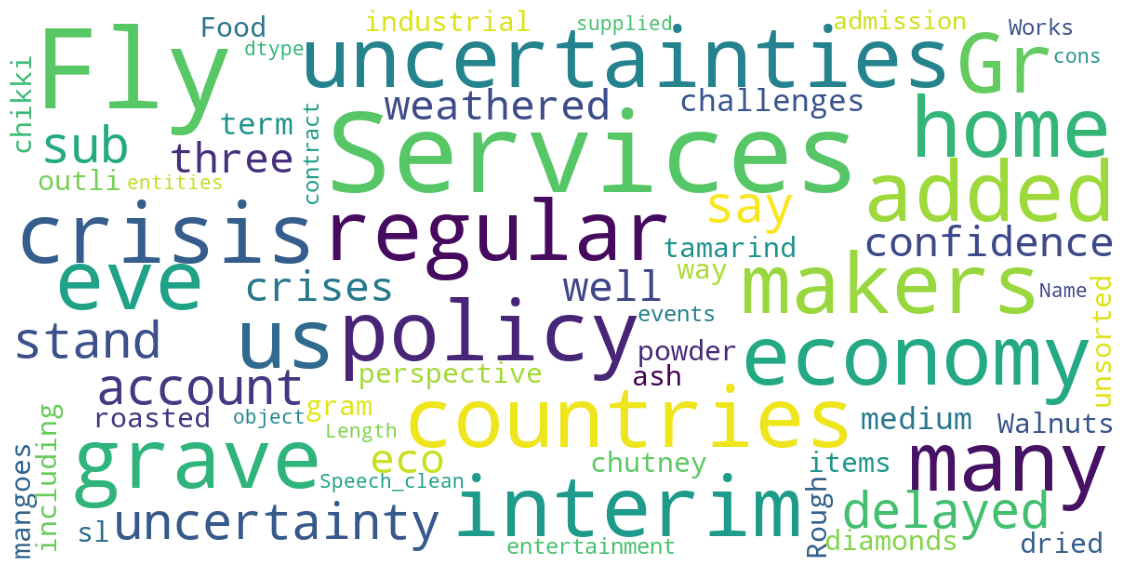

In [25]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(df["Speech_clean"])


In [0]:
# feature selection
label = "cat"
ignore_cols = [label, "Speech", "Speech_clean","Finance_Minister","Date"]
features = [c for c in df.columns if c not in ignore_cols]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[features], df[label], test_size = 0.20, random_state = 42)

We first choose which features we want to use to train our model. Then we split our data into two parts:

- one to train our model
- one to assess its performances

We will next use a Random Forest (RF) classifier for our predictions.



In [32]:
# train a random forest classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

# show feature importance
feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(20)

,feature,importance
0,sentiment_vadar,0.636557
743,word_growth,0.012887
3,doc2vec_vector_2,0.009831
408,word_credit,0.008848
822,word_increase,0.008758
1225,word_poor,0.008745
823,word_increased,0.007559
446,word_deficit,0.007510
4,doc2vec_vector_3,0.007447
5,doc2vec_vector_4,0.005789


The most important features are indeed the ones that come from the previous sentiment analysis. The vector representations of the texts also have a lot of importance in our training. Some words appear to have a fairly good importance as well.

In [36]:
import sklearn.metrics as metrics
predicted = rf.predict(X_test)
print("RF accuracy",metrics.accuracy_score(y_test, predicted))
print("RF F1 Score",metrics.f1_score(y_test, predicted, average='weighted'))

RF accuracy 0.9975346687211094
RF F1 Score 0.9975308477188283


In [81]:
from gensim.models import word2vec

tokenized_corpus = [nltk.word_tokenize(doc) for doc in df.Speech_clean]

# Set values for various parameters
feature_size = 15    # Word vector dimensionality  
window_context = 20  # Context window size                                                                                    
min_word_count = 10   # Minimum word count                        
sample = 1e-3        # Downsample setting for frequent words
sg = 1               # skip-gram model

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sg=sg, sample=sample, iter=5000)
w2v_model

In [0]:
w2v_model.save("/content/drive/My Drive/Capstone Project - NLP/Harsh/Project_Checkpoints/word2vec_latest.model")

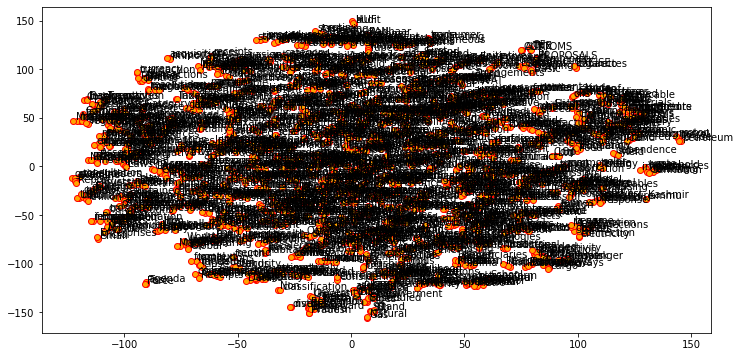

In [83]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# visualize embeddings
from sklearn.manifold import TSNE

words = w2v_model.wv.index2word
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=101, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [88]:
df.shape

(16225, 1811)

# Transfer Learning

In [0]:
import numpy as np
import pandas as pd
from fastai import *
from fastai.text import *
from fastai.vision import *
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [50]:
# Train & test split
df_train, df_test = train_test_split(df[['cat', 'Speech_clean']], test_size=0.2)
df_test.head()

,cat,Speech_clean
232,0,e Silica Tubes Textile
965,0,transfers nature capital expenditure
688,1,National Urban Health Mission launched encompass
593,0,processing industry lot fruits vegetables grow...
1428,0,provide fillip capital goods consumer durables...


In [51]:
#In fastai library, preprocessing text holds in a single line! It does behind the scene the different steps of preprocessing: cleaning, tokenizing, indexing, building vocabulary, etc.


data_lm = TextLMDataBunch.from_df('./', df_train, df_test)

In [52]:
data_lm.vocab.itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'tax',
 'provide',
 'income',
 'not',
 'development',
 'scheme',
 'financial',
 'national',
 'infrastructure',
 'services',
 'excise']

In [54]:
#Then, rather than training a sentiment analysis model directly from scratch, we will fine-tune a pretrainde language model whose weights are available in fastai library. 
#It uses the AWD_LSTM architecture, a LSTM network without attention but regularized with adaptive dropout.
#https://arxiv.org/pdf/1708.02182.pdf

learn = language_model_learner(data_lm, AWD_LSTM, pretrained=URLs.WT103_FWD, drop_mult=0.5)

In [55]:
#To see how it is pretrained, we can try to generate sentences with it:

# xxbos token stands for the beggining of a sentence
learn.predict('What', 100)

'What What Is Real and What Come Well When You Took It is an Indigenous Art Collection covered in digital format issue entitled In Short Times reported during Beyond the Modern Time Period in its history of South China New Year in the Village of East Till Death Council from April tell October Revolution to November War of the Middle Country in September recognition'

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


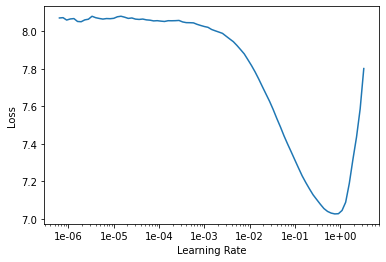

In [56]:
#Even if they don't make any sense, the generated sentences seem grammatically correct!

learn.lr_find()
learn.recorder.plot()

In [57]:
# First, fit only the last softmax layer
learn.freeze_to(-1)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,6.875775,5.434957,0.185714,00:02


In [58]:
# Then unfreeze the model and fit it again
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,5.812062,4.967130,0.285714,00:03
1,5.563069,4.607084,0.257143,00:03
2,5.344485,4.542888,0.271429,00:03
3,5.170097,4.533114,0.328571,00:03
4,5.044673,4.509791,0.328571,00:03


In [0]:
#We see here that the accuracy is about 30%, which means that our language model predict correctly the next word with a 0.3 probability. This is quite good for 1 min of training but especially only with 10000 training examples ! ^^

#We can also generate text with our language model:

In [60]:
print(learn.predict('xxbos', n_words=100))

xxbos report change Banks Banks become Banks find banks credit xxbos corrected xxbos c Aushadhi Mantri Jan Pmegp xxbos offices courses implement technical innovation AUGUST resource xxbos these developments produce xxbos premium expected face xxbos Achieve objective empower KISAN xxbos involving Excise xxbos trade Payable xxbos Mw solar power plant resort Xxbos Wool Market Marketing xxbos conduct work agenda Cooperatives raising xxbos ca incentives decade taken passage xxbos Drinking water abuse difficult xxbos first met major industry objectives xxbos order enhance


In [0]:
#The language model now generates sentences adapted to the context of the data we just trained it on!

# Save the encoder
learn.save_encoder('fine_enc')

In [62]:
#Train a sentiment analysis model
# Preprocess data
data_clas = TextClasDataBunch.from_df('./', df_train, df_test, vocab=data_lm.vocab, bs=32)

In [63]:
# Build a classifier with the same architechure and weights as the language model we've just trained 
classifier = text_classifier_learner(data_clas, drop_mult=0.5, arch=AWD_LSTM)
classifier.load_encoder('fine_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (12980 items)
x: TextList
xxbos currently long term capital gains arising,xxbos requiring taxpayers attend xxmaj income tax office,xxbos little tell xxunk,xxbos held abroad,xxbos xxmaj fertilizer xxmaj control xxmaj order
y: CategoryList
1,0,0,0,0
Path: .;

Valid: LabelList (3245 items)
x: TextList
xxbos e xxmaj silica xxmaj tubes xxmaj textile,xxbos transfers nature capital expenditure,xxbos xxmaj national xxmaj urban xxmaj health xxmaj mission launched xxunk,xxbos processing industry lot fruits vegetables grown farmers,xxbos provide fillip capital goods consumer durables automobile
y: CategoryList
0,0,1,0,0
Path: .;

Test: None, model=SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(5424, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(5424, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 115

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


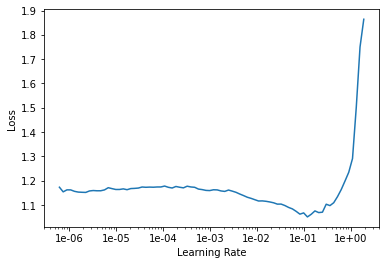

In [64]:
classifier.lr_find()
classifier.recorder.plot()

In [65]:
classifier.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.736893,0.666776,0.697997,00:07


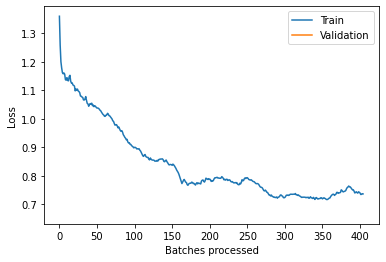

In [66]:
classifier.recorder.plot_losses()

In [0]:
#In only 1 epoch with 10K samples, we reached more than .69% accuracy !!

#Let's see if we can improve this score with some Hyperparameter tuning techniques presented in the ULMfit paper.

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


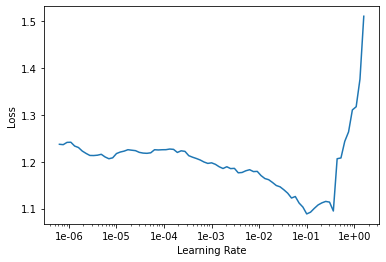

In [69]:
#Hyperparameters tuning techniques
#Discriminative learning rates
#Discriminative learning rates is a technique which consists on applying different learning rates to each layer of the network. 
#As you go from layers to layers, we need to decrease the learning rate as lowest levels represent the most general knowledge (Yosinki et al. 2014).

classifier = text_classifier_learner(data_clas, drop_mult=0.5, arch=AWD_LSTM)
classifier.load_encoder('fine_enc')
classifier.lr_find()
classifier.recorder.plot()

In [70]:
classifier.fit_one_cycle(1, slice(1e-4, 1e-2), moms=(0.8, 0.7))


epoch,train_loss,valid_loss,accuracy,time
0,0.743461,0.672837,0.705393,00:07


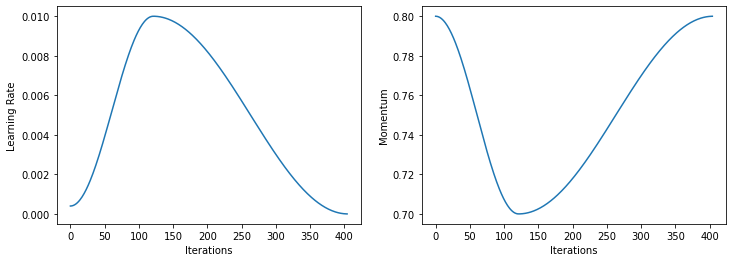

In [71]:
#One cycle learning
#One cycle learning is a technique that is commoly used in fastai library. 
#It consists on a cycle of learning rate, which starts low, increases to the maximum value passed in the fit_one_cycle function, then decreases. 
#It prevents our network from overfitting.

classifier.recorder.plot_lr(show_moms=True)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


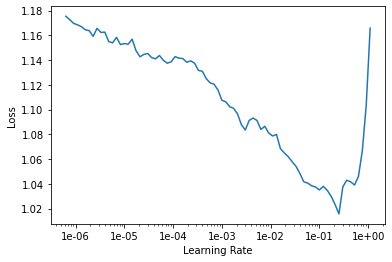

In [73]:
#Gradual unfreezing
#Rather than fine-tuning all layers at once, ULMfit paper experiments a gradual unfreezing from the last layer to the lowest ones, each time fitting one single epoch.
classifier = text_classifier_learner(data_clas, drop_mult=0.5, arch=AWD_LSTM)
classifier.load_encoder('fine_enc')
classifier.lr_find()
classifier.recorder.plot()

In [74]:
classifier.freeze_to(-1)
classifier.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.773049,0.695892,0.686287,00:07


In [75]:
classifier.unfreeze()
classifier.freeze_to(-2)
classifier.fit_one_cycle(1, slice(1e-4, 5e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.686403,0.601613,0.734361,00:08


In [76]:
classifier.unfreeze()
classifier.freeze_to(-3)
classifier.fit_one_cycle(1, slice(1e-5, 1e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.630879,0.548117,0.775655,00:11


In [77]:
classifier.unfreeze()
classifier.fit_one_cycle(1, slice(1e-4/100., 1e-4), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.553151,0.540238,0.779969,00:13


In [0]:
import pickle
#DATA_PATH = "/content/"
infile = open('/content/drive/My Drive/Capstone Project - NLP/Speech_df (1).pkl','rb')
df_classification = pickle.load(infile)

In [0]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

sentiment=[]
for sentence in df_classification.Speech_clean:
  sentiment.append(analyser.polarity_scores(sentence)['compound'])

df_classification['sentiment_vadar']=sentiment

In [92]:
df_classification

,Finance_Minister,Date,Speech,Speech_clean,sentiment_vadar
0,Pranab Mukherjee,"February 26, 2010","In 2009, when I presented the interim Budget i...",interim regular economy grave uncertainties Gr...,-0.7506
1,Pranab Mukherjee,"February 26, 2010","2. It was not clear to us, as also to...",not us policy makers many countries crisis eve...,-0.7650
2,Pranab Mukherjee,"February 26, 2010","3. At home, there was added uncertain...",At home added uncertainty account delayed sub ...,-0.5719
3,Pranab Mukherjee,"February 26, 2010","4. Today, as I stand before you, I ca...",stand say confidence weathered crises well eco...,0.7951
4,Pranab Mukherjee,"February 26, 2010",5. The three challenges and the mediu...,three challenges medium term perspective outli...,0.4019
...,...,...,...,...,...
272,Nirmala Sitharaman,"July, 5, 2019","(a) Food items such as chikki, chutney powder ...",Food items chikki chutney powder b Fly ash fly...,-0.7783
273,Nirmala Sitharaman,"July, 5, 2019","(a) Walnuts, tamarind dried, roasted gram, man...",Walnuts tamarind dried roasted gram mangoes sl...,0.8481
274,Nirmala Sitharaman,"July, 5, 2019",(a) Rough industrial diamonds including unsort...,Rough industrial diamonds including unsorted r...,0.9337
276,Nirmala Sitharaman,"July, 5, 2019",(a) Services by way of admission to entertainm...,Services way admission entertainment events am...,0.6486


In [0]:
df_selected = df_classification[['Speech_clean','sentiment_vadar']]

In [0]:
df_selected["sentiment_vadar"] = df_selected["sentiment_vadar"].apply(lambda x: 1 if x > 0 else 0)

In [95]:
df_selected

,Speech_clean,sentiment_vadar
0,interim regular economy grave uncertainties Gr...,0
1,not us policy makers many countries crisis eve...,0
2,At home added uncertainty account delayed sub ...,0
3,stand say confidence weathered crises well eco...,1
4,three challenges medium term perspective outli...,1
...,...,...
272,Food items chikki chutney powder b Fly ash fly...,0
273,Walnuts tamarind dried roasted gram mangoes sl...,1
274,Rough industrial diamonds including unsorted r...,1
276,Services way admission entertainment events am...,1


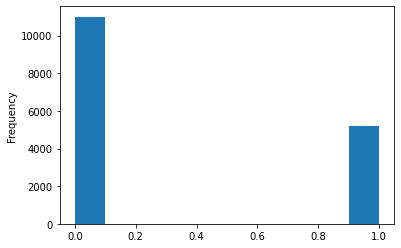

In [96]:
%matplotlib inline
import matplotlib.pyplot as plt

df_selected["sentiment_vadar"].plot.hist()
plt.show()

In [0]:
from sklearn.model_selection import train_test_split

# Input: "reviewText", "rating" and "time"
# Target: "log_votes"
X_train, X_val, y_train, y_val = train_test_split(df_selected[["Speech_clean"]],
                                                  df_selected["sentiment_vadar"].tolist(),
                                                  test_size=0.10,
                                                  shuffle=True
                                                 )

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Initialize the binary count vectorizer
#tfidf_vectorizer = CountVectorizer(binary=True,
#                                   max_features=200    # Limit the vocabulary size
#                                  )
# Fit and transform
#X_train_text_vectors = tfidf_vectorizer.fit_transform(X_train["Clean_english"].tolist())
# Only transform
#X_val_text_vectors = tfidf_vectorizer.transform(X_val["Clean_english"].tolist())

# build BOW features on train speeches
cv = CountVectorizer(binary=False, min_df=0.0, max_df=1.0, ngram_range=(1,2))
cv_train_features = cv.fit_transform(X_train["Speech_clean"].tolist())
# build TFIDF features on train speeches
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
tv_train_features = tv.fit_transform(X_train["Speech_clean"].tolist())


In [0]:
# transform test reviews into features
cv_test_features = cv.transform(X_val['Speech_clean'])
tv_test_features = tv.transform(X_val['Speech_clean'])

In [102]:
print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

BOW model:> Train features shape: (14602, 59430)  Test features shape: (1623, 59430)
TFIDF model:> Train features shape: (14602, 59430)  Test features shape: (1623, 59430)


# Model Training, Prediction and Performance Evaluation

In [0]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression

lr = LogisticRegression(penalty='l2', max_iter=100, C=1)
svm = SGDClassifier(loss='hinge', n_iter_no_change=100)
# Model Generation Using Multinomial Naive Bayes
clf = MultinomialNB()
# Model Generation Using Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
# Model Generation Using XGBoost
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV
xgb_model = XGBClassifier(max_depth=6,n_esimators=200) #got it from Grid search in other notebook

In [0]:
def train_predict_model(classifier, 
                        train_features, train_labels, 
                        test_features, test_labels):
    # build model    
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features) 
    return predictions    

In [0]:
def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))


In [0]:
def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, 
                                  classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, 
                             classes=classes)

In [0]:
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report)

In [0]:
def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm) 
    print(cm_frame)

In [163]:
# Logistic Regression model on BOW features
lr_bow_predictions = train_predict_model(classifier=lr, 
                                             train_features=cv_train_features, train_labels=y_train,
                                             test_features=cv_test_features, test_labels=y_val)
display_model_performance_metrics(true_labels=y_val, predicted_labels=lr_bow_predictions,
                                      classes=[1, 0])

Model Performance metrics:
------------------------------
Accuracy: 0.9144
Precision: 0.9182
Recall: 0.9144
F1 Score: 0.9118

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.96      0.78      0.86       538
           0       0.90      0.98      0.94      1085

    accuracy                           0.91      1623
   macro avg       0.93      0.88      0.90      1623
weighted avg       0.92      0.91      0.91      1623


Prediction Confusion Matrix:
------------------------------
     0     1
0  417   121
1   18  1067


In [164]:
# Logistic Regression model on TF-IDF features
lr_tfidf_predictions = train_predict_model(classifier=lr, 
                                               train_features=tv_train_features, train_labels=y_train,
                                               test_features=tv_test_features, test_labels=y_val)
display_model_performance_metrics(true_labels=y_val, predicted_labels=lr_tfidf_predictions,
                                      classes=[1, 0])

Model Performance metrics:
------------------------------
Accuracy: 0.886
Precision: 0.8954
Recall: 0.886
F1 Score: 0.8802

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.96      0.68      0.80       538
           0       0.86      0.99      0.92      1085

    accuracy                           0.89      1623
   macro avg       0.91      0.84      0.86      1623
weighted avg       0.90      0.89      0.88      1623


Prediction Confusion Matrix:
------------------------------
     0     1
0  368   170
1   15  1070


In [166]:
# Stochastic Gradient Descent model on BOW features

svm_bow_predictions = train_predict_model(classifier=svm, 
                                             train_features=cv_train_features, train_labels=y_train,
                                             test_features=cv_test_features, test_labels=y_val)
display_model_performance_metrics(true_labels=y_val, predicted_labels=svm_bow_predictions,
                                      classes=[1, 0])

Model Performance metrics:
------------------------------
Accuracy: 0.9396
Precision: 0.9404
Recall: 0.9396
F1 Score: 0.9387

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.96      0.86      0.90       538
           0       0.93      0.98      0.96      1085

    accuracy                           0.94      1623
   macro avg       0.94      0.92      0.93      1623
weighted avg       0.94      0.94      0.94      1623


Prediction Confusion Matrix:
------------------------------
     0     1
0  461    77
1   21  1064


In [167]:
# Stochastic Gradient Descent model on TF-IDF features

svm_tfidf_predictions = train_predict_model(classifier=svm, 
                                             train_features=tv_train_features, train_labels=y_train,
                                             test_features=tv_test_features, test_labels=y_val)
display_model_performance_metrics(true_labels=y_val, predicted_labels=svm_bow_predictions,
                                      classes=[1, 0])

Model Performance metrics:
------------------------------
Accuracy: 0.9396
Precision: 0.9404
Recall: 0.9396
F1 Score: 0.9387

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.96      0.86      0.90       538
           0       0.93      0.98      0.96      1085

    accuracy                           0.94      1623
   macro avg       0.94      0.92      0.93      1623
weighted avg       0.94      0.94      0.94      1623


Prediction Confusion Matrix:
------------------------------
     0     1
0  461    77
1   21  1064


In [169]:
# Naive Bayes model on BOW features

clf_bow_predictions = train_predict_model(classifier=clf, 
                                             train_features=cv_train_features, train_labels=y_train,
                                             test_features=cv_test_features, test_labels=y_val)
display_model_performance_metrics(true_labels=y_val, predicted_labels=svm_bow_predictions,
                                      classes=[1, 0])

Model Performance metrics:
------------------------------
Accuracy: 0.9396
Precision: 0.9404
Recall: 0.9396
F1 Score: 0.9387

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.96      0.86      0.90       538
           0       0.93      0.98      0.96      1085

    accuracy                           0.94      1623
   macro avg       0.94      0.92      0.93      1623
weighted avg       0.94      0.94      0.94      1623


Prediction Confusion Matrix:
------------------------------
     0     1
0  461    77
1   21  1064


In [170]:
# Naive Bayes model on TF-IDF features

clf_tfidf_predictions = train_predict_model(classifier=clf, 
                                             train_features=tv_train_features, train_labels=y_train,
                                             test_features=tv_test_features, test_labels=y_val)
display_model_performance_metrics(true_labels=y_val, predicted_labels=svm_bow_predictions,
                                      classes=[1, 0])

Model Performance metrics:
------------------------------
Accuracy: 0.9396
Precision: 0.9404
Recall: 0.9396
F1 Score: 0.9387

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.96      0.86      0.90       538
           0       0.93      0.98      0.96      1085

    accuracy                           0.94      1623
   macro avg       0.94      0.92      0.93      1623
weighted avg       0.94      0.94      0.94      1623


Prediction Confusion Matrix:
------------------------------
     0     1
0  461    77
1   21  1064


In [171]:
# Random Forest model on BOW features

rf_bow_predictions = train_predict_model(classifier=rf, 
                                             train_features=cv_train_features, train_labels=y_train,
                                             test_features=cv_test_features, test_labels=y_val)
display_model_performance_metrics(true_labels=y_val, predicted_labels=svm_bow_predictions,
                                      classes=[1, 0])

Model Performance metrics:
------------------------------
Accuracy: 0.9396
Precision: 0.9404
Recall: 0.9396
F1 Score: 0.9387

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.96      0.86      0.90       538
           0       0.93      0.98      0.96      1085

    accuracy                           0.94      1623
   macro avg       0.94      0.92      0.93      1623
weighted avg       0.94      0.94      0.94      1623


Prediction Confusion Matrix:
------------------------------
     0     1
0  461    77
1   21  1064


In [172]:
# Random Forest model on TF - IDF features

rf_tfidf_predictions = train_predict_model(classifier=rf, 
                                             train_features=tv_train_features, train_labels=y_train,
                                             test_features=tv_test_features, test_labels=y_val)
display_model_performance_metrics(true_labels=y_val, predicted_labels=svm_bow_predictions,
                                      classes=[1, 0])

Model Performance metrics:
------------------------------
Accuracy: 0.9396
Precision: 0.9404
Recall: 0.9396
F1 Score: 0.9387

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.96      0.86      0.90       538
           0       0.93      0.98      0.96      1085

    accuracy                           0.94      1623
   macro avg       0.94      0.92      0.93      1623
weighted avg       0.94      0.94      0.94      1623


Prediction Confusion Matrix:
------------------------------
     0     1
0  461    77
1   21  1064


In [173]:
# Gradient Boost on BOW features

XGB_bow_predictions = train_predict_model(classifier=xgb_model, 
                                             train_features=cv_train_features, train_labels=y_train,
                                             test_features=cv_test_features, test_labels=y_val)
display_model_performance_metrics(true_labels=y_val, predicted_labels=svm_bow_predictions,
                                      classes=[1, 0])

Model Performance metrics:
------------------------------
Accuracy: 0.9396
Precision: 0.9404
Recall: 0.9396
F1 Score: 0.9387

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.96      0.86      0.90       538
           0       0.93      0.98      0.96      1085

    accuracy                           0.94      1623
   macro avg       0.94      0.92      0.93      1623
weighted avg       0.94      0.94      0.94      1623


Prediction Confusion Matrix:
------------------------------
     0     1
0  461    77
1   21  1064


In [174]:
# Gradient Boost on TF-IDF features

XGB_tfidf_predictions = train_predict_model(classifier=xgb_model, 
                                             train_features=tv_train_features, train_labels=y_train,
                                             test_features=tv_test_features, test_labels=y_val)
display_model_performance_metrics(true_labels=y_val, predicted_labels=svm_bow_predictions,
                                      classes=[1, 0])

Model Performance metrics:
------------------------------
Accuracy: 0.9396
Precision: 0.9404
Recall: 0.9396
F1 Score: 0.9387

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.96      0.86      0.90       538
           0       0.93      0.98      0.96      1085

    accuracy                           0.94      1623
   macro avg       0.94      0.92      0.93      1623
weighted avg       0.94      0.94      0.94      1623


Prediction Confusion Matrix:
------------------------------
     0     1
0  461    77
1   21  1064


# Newer Supervised Deep Learning Models

In [0]:
normalized_corpus_for_classification = df_selected[["Speech_clean"]]

In [0]:
df_new = pd.DataFrame(normalized_corpus_for_classification,columns=['Speech_clean'])

In [214]:
df_new.shape

(16225, 1)

In [0]:
def analyze_sentiment_vader_lexicon(speech, 
                                    threshold=0.1,
                                    verbose=False):
      
    # analyze the sentiment for review
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(review)
    # get aggregate scores and final sentiment
    agg_score = scores['compound']
    final_sentiment = 'positive' if agg_score >= threshold\
                                   else 'negative'
    if verbose:
        # display detailed sentiment statistics
        positive = str(round(scores['pos'], 2)*100)+'%'
        final = round(agg_score, 2)
        negative = str(round(scores['neg'], 2)*100)+'%'
        neutral = str(round(scores['neu'], 2)*100)+'%'
        sentiment_frame = pd.DataFrame([[final_sentiment, final, positive,
                                        negative, neutral]])
        print(sentiment_frame)
    
    return final_sentiment

In [0]:
predicted_sentiments = [analyze_sentiment_vader_lexicon(speech, threshold=0.4, verbose=False) for speech in df_new.Speech_clean]

In [219]:
df_new['sentiment_vadar']=predicted_sentiments
df_new.head(1)

,Speech_clean,sentiment_vadar
0,interim regular economy grave uncertainties Gr...,negative


In [0]:
speeches = np.array(df_new['Speech_clean'])
sentiments = np.array(df_new['sentiment_vadar'])

train_speeches = speeches[:12000]
train_sentiments = sentiments[:12000]
test_speeches = speeches[12000:]
test_sentiments = sentiments[12000:]

Prediction class label encoding

In [0]:
import gensim
import keras
from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense
from sklearn.preprocessing import LabelEncoder

In [0]:
from nltk.tokenize.toktok import ToktokTokenizer
tokenizer = ToktokTokenizer()

In [0]:
le = LabelEncoder()
num_classes=2 
# tokenize train reviews & encode train labels
tokenized_train = [tokenizer.tokenize(text)
                   for text in train_speeches]
y_tr = le.fit_transform(train_sentiments)
y_train = keras.utils.to_categorical(y_tr, num_classes)
# tokenize test reviews & encode test labels
tokenized_test = [tokenizer.tokenize(text)
                   for text in test_speeches]
y_ts = le.fit_transform(test_sentiments)
y_test = keras.utils.to_categorical(y_ts, num_classes)

In [227]:
# print class label encoding map and encoded labels
print('Sentiment class label map:', dict(zip(le.classes_, le.transform(le.classes_))))
print('Sample test label transformation:\n'+'-'*35,
      '\nActual Labels:', test_sentiments[:3], '\nEncoded Labels:', y_ts[:3], 
      '\nOne hot encoded Labels:\n', y_test[:3])

Sentiment class label map: {'negative': 0, 'positive': 1}
Sample test label transformation:
----------------------------------- 
Actual Labels: ['negative' 'negative' 'negative'] 
Encoded Labels: [0 0 0] 
One hot encoded Labels:
 [[1. 0.]
 [1. 0.]
 [1. 0.]]


# Feature Engineering with word embeddings

In [0]:
# build word2vec model
w2v_num_features = 500
w2v_model = gensim.models.Word2Vec(tokenized_train, size=w2v_num_features, window=150,
                                   min_count=10, sample=1e-3)

In [0]:
def averaged_word2vec_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    
    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.
        
        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [0]:
# generate averaged word vector features from word2vec model
avg_wv_train_features = averaged_word2vec_vectorizer(corpus=tokenized_train, model=w2v_model,
                                                     num_features=500)
avg_wv_test_features = averaged_word2vec_vectorizer(corpus=tokenized_test, model=w2v_model,
                                                    num_features=500)

In [0]:
nlp = spacy.load('en', parse = False, tag= False, entity=False)

In [0]:
# feature engineering with GloVe model
train_nlp = [nlp(item) for item in train_speeches]
train_glove_features = np.array([item.vector for item in train_nlp])

test_nlp = [nlp(item) for item in test_speeches]
test_glove_features = np.array([item.vector for item in test_nlp])

In [244]:
print('Word2Vec model:> Train features shape:', avg_wv_train_features.shape, ' Test features shape:', avg_wv_test_features.shape)
print('GloVe model:> Train features shape:', train_glove_features.shape, ' Test features shape:', test_glove_features.shape)

Word2Vec model:> Train features shape: (12000, 500)  Test features shape: (4225, 500)
GloVe model:> Train features shape: (12000, 96)  Test features shape: (4225, 96)


# Modeling with deep neural networks

Building Deep neural network architecture



In [0]:
def construct_deepnn_architecture(num_input_features):
    dnn_model = Sequential()
    dnn_model.add(Dense(512, activation='relu', input_shape=(num_input_features,)))
    dnn_model.add(Dropout(0.5))
    dnn_model.add(Dense(2))
    dnn_model.add(Activation('softmax'))
    dnn_model.compile(loss='categorical_crossentropy', optimizer='adam',                 
                      metrics=['accuracy'])
    return dnn_model

In [0]:
w2v_dnn = construct_deepnn_architecture(num_input_features=500)

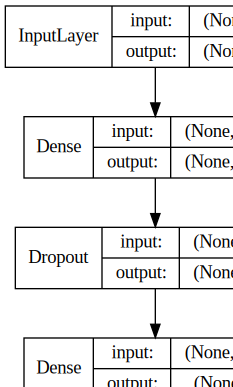

In [247]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(w2v_dnn, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [262]:
batch_size = 100
w2v_dnn.fit(avg_wv_train_features, y_train, epochs=5, batch_size=batch_size, 
            shuffle=True, validation_split=0.1, verbose=1)

Train on 10800 samples, validate on 1200 samples
Epoch 1/5
10800/10800 [==============================] - 0s 41us/step - loss: 0.4478 - accuracy: 0.8306 - val_loss: 0.4466 - val_accuracy: 0.8383
Epoch 2/5
10800/10800 [==============================] - 0s 41us/step - loss: 0.4481 - accuracy: 0.8306 - val_loss: 0.4446 - val_accuracy: 0.8383
Epoch 3/5
10800/10800 [==============================] - 0s 42us/step - loss: 0.4470 - accuracy: 0.8306 - val_loss: 0.4496 - val_accuracy: 0.8383
Epoch 4/5
10800/10800 [==============================] - 0s 41us/step - loss: 0.4467 - accuracy: 0.8306 - val_loss: 0.4445 - val_accuracy: 0.8383
Epoch 5/5
10800/10800 [==============================] - 0s 44us/step - loss: 0.4478 - accuracy: 0.8306 - val_loss: 0.4442 - val_accuracy: 0.8383


In [0]:
y_pred = w2v_dnn.predict_classes(avg_wv_test_features)
predictions = le.inverse_transform(y_pred)

In [0]:
#Define a function to evaluate the model
def display_model_performance_results(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, 
                                  classes=classes)

In [265]:
display_model_performance_results(true_labels=test_sentiments, predicted_labels=predictions, 
                                      classes=['negative', 'positive'])

Model Performance metrics:
------------------------------
Accuracy: 0.8485
Precision: 0.72
Recall: 0.8485
F1 Score: 0.779

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    negative       0.85      1.00      0.92      3585
    positive       0.00      0.00      0.00       640

    accuracy                           0.85      4225
   macro avg       0.42      0.50      0.46      4225
weighted avg       0.72      0.85      0.78      4225



In [0]:
glove_dnn = construct_deepnn_architecture(num_input_features=96)

In [267]:
batch_size = 5
glove_dnn.fit(train_glove_features, y_train, epochs=5, batch_size=batch_size, 
              shuffle=True, validation_split=0.1, verbose=1)

Train on 10800 samples, validate on 1200 samples
Epoch 1/5
10800/10800 [==============================] - 8s 758us/step - loss: 0.4441 - accuracy: 0.8203 - val_loss: 0.4166 - val_accuracy: 0.8400
Epoch 2/5
10800/10800 [==============================] - 8s 758us/step - loss: 0.4199 - accuracy: 0.8290 - val_loss: 0.4167 - val_accuracy: 0.8408
Epoch 3/5
10800/10800 [==============================] - 8s 743us/step - loss: 0.4127 - accuracy: 0.8294 - val_loss: 0.4266 - val_accuracy: 0.8408
Epoch 4/5
10800/10800 [==============================] - 8s 741us/step - loss: 0.4109 - accuracy: 0.8300 - val_loss: 0.4250 - val_accuracy: 0.8400
Epoch 5/5
10800/10800 [==============================] - 8s 777us/step - loss: 0.4032 - accuracy: 0.8313 - val_loss: 0.4253 - val_accuracy: 0.8433


In [0]:
y_pred = glove_dnn.predict_classes(test_glove_features)
predictions = le.inverse_transform(y_pred)

In [269]:
display_model_performance_results(true_labels=test_sentiments, predicted_labels=predictions, 
                                      classes=['negative', 'positive'])

Model Performance metrics:
------------------------------
Accuracy: 0.8497
Precision: 0.8263
Recall: 0.8497
F1 Score: 0.7836

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    negative       0.85      1.00      0.92      3585
    positive       0.69      0.01      0.03       640

    accuracy                           0.85      4225
   macro avg       0.77      0.51      0.47      4225
weighted avg       0.83      0.85      0.78      4225



# Sentiment Analysis - Advanced Deep Learning

In [0]:
#Tokenize train & test datasets
tokenized_train = [tokenizer.tokenize(text) for text in train_speeches]
tokenized_test = [tokenizer.tokenize(text) for text in test_speeches]

In [271]:
#Build Vocabulary Mapping (word to index)
from collections import Counter

# build word to index vocabulary
token_counter = Counter([token for review in tokenized_train for token in review])
vocab_map = {item[0]: index+1 for index, item in enumerate(dict(token_counter).items())}
max_index = np.max(list(vocab_map.values()))
vocab_map['PAD_INDEX'] = 0
vocab_map['NOT_FOUND_INDEX'] = max_index+1
vocab_size = len(vocab_map)
# view vocabulary size and part of the vocabulary map
print('Vocabulary Size:', vocab_size)
print('Sample slice of vocabulary map:', dict(list(vocab_map.items())[10:20]))

Vocabulary Size: 9973
Sample slice of vocabulary map: {'weak': 11, 'capacity': 12, 'sustain': 13, 'high': 14, 'growth': 15, 'serious': 16, 'threat': 17, 'widespread': 18, 'economic': 19, 'slowdown': 20}


In [272]:
#Encode and Pad datasets & Encode prediction class labels
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

# get max length of train corpus and initialize label encoder
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0
max_len = np.max([len(review) for review in tokenized_train])

## Train reviews data corpus
# Convert tokenized text reviews to numeric vectors
train_X = [[vocab_map[token] for token in tokenized_review] for tokenized_review in tokenized_train]
train_X = sequence.pad_sequences(train_X, maxlen=max_len) # pad 
## Train prediction class labels
# Convert text sentiment labels (negative\positive) to binary encodings (0/1)
train_y = le.fit_transform(train_sentiments)

## Test reviews data corpus
# Convert tokenized text reviews to numeric vectors
test_X = [[vocab_map[token] if vocab_map.get(token) else vocab_map['NOT_FOUND_INDEX'] 
           for token in tokenized_review] 
              for tokenized_review in tokenized_test]
test_X = sequence.pad_sequences(test_X, maxlen=max_len)
## Test prediction class labels
# Convert text sentiment labels (negative\positive) to binary encodings (0/1)
test_y = le.transform(test_sentiments)

# view vector shapes
print('Max length of train review vectors:', max_len)
print('Train review vectors shape:', train_X.shape, ' Test review vectors shape:', test_X.shape)

Max length of train review vectors: 76
Train review vectors shape: (12000, 76)  Test review vectors shape: (4225, 76)


# Build the LSTM Model Architecture

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, SpatialDropout1D
from keras.layers import LSTM

EMBEDDING_DIM = 128 # dimension for dense embeddings for each token
LSTM_DIM = 64 # total LSTM units

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [274]:
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 76, 128)           1276544   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 76, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 1,326,017
Trainable params: 1,326,017
Non-trainable params: 0
_________________________________________________________________
None


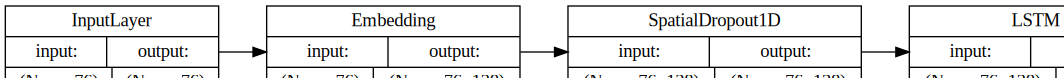

In [275]:
#Visualize model architecture
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='LR').create(prog='dot', format='svg'))

In [276]:
#Train the model
batch_size = 100
model.fit(train_X, train_y, epochs=5, batch_size=batch_size, 
          shuffle=True, validation_split=0.1, verbose=1)

Train on 10800 samples, validate on 1200 samples
Epoch 1/5
10800/10800 [==============================] - 28s 3ms/step - loss: 0.4267 - accuracy: 0.8286 - val_loss: 0.3546 - val_accuracy: 0.8425
Epoch 2/5
10800/10800 [==============================] - 27s 2ms/step - loss: 0.2258 - accuracy: 0.9081 - val_loss: 0.2382 - val_accuracy: 0.9183
Epoch 3/5
10800/10800 [==============================] - 28s 3ms/step - loss: 0.0932 - accuracy: 0.9673 - val_loss: 0.2436 - val_accuracy: 0.9117
Epoch 4/5
10800/10800 [==============================] - 27s 2ms/step - loss: 0.0489 - accuracy: 0.9836 - val_loss: 0.2759 - val_accuracy: 0.9183
Epoch 5/5
10800/10800 [==============================] - 27s 3ms/step - loss: 0.0256 - accuracy: 0.9919 - val_loss: 0.3399 - val_accuracy: 0.9133


# Predict and Evaluate Model Performance

In [0]:
pred_test = model.predict_classes(test_X)
predictions = le.inverse_transform(pred_test.flatten())

In [278]:
display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=predictions, 
                                      classes=['positive', 'negative'])

Model Performance metrics:
------------------------------
Accuracy: 0.928
Precision: 0.9249
Recall: 0.928
F1 Score: 0.9255

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    positive       0.81      0.69      0.74       640
    negative       0.95      0.97      0.96      3585

    accuracy                           0.93      4225
   macro avg       0.88      0.83      0.85      4225
weighted avg       0.92      0.93      0.93      4225


Prediction Confusion Matrix:
------------------------------
     0     1
0  439   201
1  103  3482


# Getting best performance with LSTM